In [1]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import numpy as np
import os
import trimesh
import b3d
from jax.scipy.spatial.transform import Rotation as Rot
from b3d import Pose
from b3d.utils import unproject_depth
import rerun as rr


In [2]:
rr.init("demo.py")
rr.connect("127.0.0.1:8812")

In [305]:
width=100
height=100
fx=50.0
fy=50.0
cx=50.0
cy=50.0
near=0.001
far=16.0
renderer = b3d.Renderer(
    width, height, fx, fy, cx, cy, near, far
)

In [306]:
## Render color
from pathlib import Path
mesh_path = Path(b3d.__file__).parents[1] / "assets/006_mustard_bottle/textured_simple.obj"
mesh = trimesh.load(mesh_path)

vertices = jnp.array(mesh.vertices) * 20.0
vertices = vertices - vertices.mean(0)
faces = jnp.array(mesh.faces)
vertex_colors = jnp.array(mesh.visual.to_color().vertex_colors)[...,:3] / 255.0
ranges = jnp.array([[0, len(faces)]])

pose = Pose.from_position_and_target(
    jnp.array([3.0, 3.0, 0.0]),
    jnp.array([0.0, 2, 0.0])

).inverse()

In [307]:
rr.log(
    "/3d/mesh",
    rr.Mesh3D(
        vertex_positions=vertices,
        indices=faces,
        vertex_colors=vertex_colors
    ),
    timeless=True
)

In [308]:
num_frames = 5

In [309]:
poses = [
    pose
]
delta_pose = Pose(
    jnp.array([0.0, 0.5, 0.0]),
    Rot.from_euler("zyx", [-1.0, 0.1, 2.0], degrees=True).as_quat()
)
for t in range(num_frames - 1):
    poses.append(poses[-1] @ delta_pose)


all_gt_poses = Pose.stack_poses(poses)

In [310]:
all_gt_poses.as_matrix()[:,None,...].shape

(5, 1, 4, 4)

In [316]:
vertex_colors

Array([[0.8823529 , 0.7843137 , 0.23921567],
       [0.890196  , 0.7921568 , 0.25490195],
       [0.8823529 , 0.78823525, 0.2352941 ],
       ...,
       [0.79999995, 0.67843133, 0.13333333],
       [0.8470588 , 0.6980392 , 0.16470587],
       [0.8431372 , 0.69019604, 0.15686274]],      dtype=float32, weak_type=True)

In [311]:
images, depths = renderer.render_attribute_many(all_gt_poses.as_matrix()[:,None,...], vertices, faces, ranges, vertex_colors)

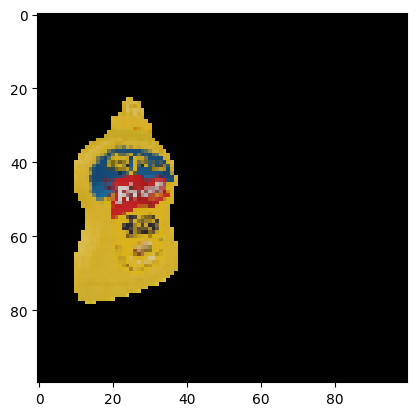

In [312]:
plt.imshow(images[0])

In [11]:
images[4].shape

(100, 100, 3)

In [12]:
## drawing a triangle of triangles in the scene

In [13]:
# mesh objects can be created from existing faces and vertex data
mesh = trimesh.Trimesh(vertices=[[0, 0, 0], [0, 0, 1], [0, 1, 0], [1, 1, 1], [1, 1, 2], [1, 2, 1]],
                       faces=[[0, 1, 2], [3, 4, 5]])

In [14]:
vertices = jnp.array(mesh.vertices) * 20.0
vertices = vertices - vertices.mean(0)
faces = jnp.array(mesh.faces)
#vertex_colors = jnp.array(mesh.visual.to_color().vertex_colors)[...,:3] / 255.0


rr.log(
    "/3d/mesh2",
    rr.Mesh3D(
        vertex_positions=mesh.vertices,
        indices=mesh.faces,
        vertex_colors=jnp.array([[255,0,0], [0,255,0], [255,0,0], [0,255,0], [255,0,0], [0,255,0]])
    ),
    timeless=True
)

In [15]:
# propose circle mask
# pick vertices on the mask
# make triangle based on texture
# generate movement proposals
# marginalize out over movement proposals to find the best features

In [360]:
indices = jnp.indices((height, width)).transpose(1,2,0)
# restrict to circles not within 3 of the edge
edge_buffer = triangle_boundary_radius = 3
indices = indices[edge_buffer:height-edge_buffer, edge_buffer:width-edge_buffer, :]
indices = indices.reshape(-1, 2)


In [361]:
key = jax.random.PRNGKey(15)
triangles = 500
choices = jax.random.choice(key, indices, shape=(triangles,))

In [362]:
# r = jax.random.uniform(key, shape=(triangles*2,)) * triangle_radius
# theta = jax.random.uniform(key, shape=(triangles*2,)) * 2 * jnp.pi

r = triangle_boundary_radius
theta_1 = jax.random.uniform(key, shape=(triangles,)) * 2 * jnp.pi / 3 
theta_2 = theta_1 + 2 * jnp.pi / 3 
theta_3 = theta_1 + 4 * jnp.pi / 3


In [363]:
vertex1 = jnp.round(choices + jnp.array([jnp.multiply(r,jnp.cos(theta_1)), jnp.multiply(r,jnp.sin(theta_1))]).T).astype(int)
vertex2 = jnp.round(choices + jnp.array([jnp.multiply(r,jnp.cos(theta_2)), jnp.multiply(r,jnp.sin(theta_2))]).T).astype(int)
vertex3 = jnp.round(choices + jnp.array([jnp.multiply(r,jnp.cos(theta_3)), jnp.multiply(r,jnp.sin(theta_3))]).T).astype(int)

In [364]:
vertices = jnp.array([vertex1, vertex2, vertex3]).transpose(1,0,2)

In [365]:
vertices.shape

(500, 3, 2)

In [366]:
vertices_flattened = vertices.reshape(-1,2)

In [367]:
# unproject point cloud and index the depth image

In [368]:
intrinsics = (width, height, fx, fy, cx, cy, near, far)
pc = unproject_depth(depths[4], intrinsics)

In [369]:
triangle_vertices = pc[tuple(vertices_flattened.T)]

In [370]:
triangle_indices = jnp.arange(0,300).reshape(100,3)

In [371]:
mesh = trimesh.Trimesh(vertices=triangle_vertices, faces=triangle_indices)

In [372]:
rr.log(
    "/3d/mesh3",
    rr.Mesh3D(
        vertex_positions=triangle_vertices,
        indices=triangle_indices,
        #vertex_colors=jnp.array([[255,0,0], [0,255,0], [255,0,0], [0,255,0], [255,0,0], [0,255,0]])
    ),
    timeless=True
)

In [373]:
rr.log(
    '/log_cloud',
    rr.Points3D(pc.reshape(-1,3)),
    timeless=True
)

In [374]:
 #rr.log('/pinhole', rr.Pinhole(camera_xyz=…))
rr.log("world", rr.ViewCoordinates.RIGHT_HAND_Z_UP, timeless=True)
rr.log(
    "world/xyz",
    rr.Arrows3D(
        vectors=[[1, 0, 0], [0, 1, 0], [0, 0, 1]],
        colors=[[255, 0, 0], [0, 255, 0], [0, 0, 255]],
    ),
)

In [375]:
# rr.log(
#     "world/xyz",
#     rr.Arrows3D(
#         vectors=pose.inv().as_matrix()[0:3,0:3],
#         colors=[[255, 0, 0], [0, 255, 0], [0, 0, 255]],
#     ),
# )

In [376]:
pose.as_matrix()[0:3,0:3]

Array([[-3.1622779e-01,  9.4868326e-01, -8.9406967e-08],
       [ 8.9406967e-08, -4.4703484e-08, -1.0000000e+00],
       [-9.4868326e-01, -3.1622779e-01, -2.9802322e-08]], dtype=float32)

In [377]:
# subtriangles
# recursively turn each triangle into four triangle 



In [378]:
triangle_vertices = jnp.array([triangle_vertices])
triangle_indices = jnp.array([triangle_indices])

In [379]:
len(triangle_vertices[0])

1500

In [380]:
vertices_flattened.shape

(1500, 2)

In [381]:
#jax routine to interpolate

#given a list of 4 vertex meshes, returns subdivided high-resolution mesh
 
def subdivide_triangles(triangle_vertices_list, triangle_indices_list, triangle_vertex_projections):
    # input triangle 
    num_triangle_vertices = len(triangle_vertices_list)
    num_triangles = len(triangle_indices_list)
    triangle_vertices_out = jnp.zeros((num_triangle_vertices*2, 3))
    triangle_vertex_projections_out = jnp.zeros((num_triangle_vertices*2, 2))
    
    triangle_vertices_out = triangle_vertices_out.at[0:num_triangle_vertices].set(triangle_vertices_list)
    triangle_indices_list_out = jnp.zeros((num_triangles*4, 3))
    triangle_vertex_projections_out = triangle_vertex_projections_out.at[0:num_triangle_vertices].set(triangle_vertex_projections)

    for ind, triangle_indices in enumerate(triangle_indices_list):
        p1, p2, p3 = triangle_vertices_list[triangle_indices]
        m1, m2, m3 = (p1 + p2)/2, (p2 + p3)/2, (p3 + p1)/2
        p1_pix, p2_pix, p3_pix = triangle_vertex_projections[triangle_indices]
        m1_pix, m2_pix, m3_pix = (p1_pix + p2_pix)/2, (p2_pix + p3_pix)/2, (p3_pix + p1_pix)/2
        
        triangle_vertices_out = triangle_vertices_out.at[num_triangle_vertices + 3*ind:num_triangle_vertices + 3*(ind+1)].set(jnp.array([m1, m2, m3]))
        triangle_vertex_projections_out = triangle_vertex_projections_out.at[num_triangle_vertices + 3*ind:num_triangle_vertices + 3*(ind+1)].set(jnp.array([m1_pix, m2_pix, m3_pix]))
        triangle_indices_list_out = triangle_indices_list_out.at[ind].set(np.array([num_triangle_vertices + 3*ind, num_triangle_vertices + 3*ind + 1, num_triangle_vertices + 3*ind + 2]))
        triangle_indices_list_out = triangle_indices_list_out.at[num_triangles + ind].set(np.array([triangle_indices[0], num_triangle_vertices + 3*ind, num_triangle_vertices + 3*ind + 2]))
        triangle_indices_list_out = triangle_indices_list_out.at[2*num_triangles + ind].set(np.array([triangle_indices[1], num_triangle_vertices + 3*ind, num_triangle_vertices + 3*ind + 1]))
        triangle_indices_list_out = triangle_indices_list_out.at[3*num_triangles + ind].set(np.array([triangle_indices[2], num_triangle_vertices + 3*ind + 1, num_triangle_vertices + 3*ind + 2]))

    return triangle_vertices_out, triangle_indices_list_out.astype(int), jnp.round(triangle_vertex_projections_out).astype(int)
        

# todo: grab color value from nearest point

# make these individual

In [382]:
sub_v, sub_i, sub_vf = subdivide_triangles(triangle_vertices[0], triangle_indices[0], vertices_flattened)


In [383]:
rr.log(
    "/3d/mesh4",
    rr.Mesh3D(
        vertex_positions=sub_v,
        indices=sub_i[0:100],
        #vertex_colors=jnp.array([[255,0,0], [0,255,0], [255,0,0], [0,255,0], [255,0,0], [0,255,0]])
    ),
    timeless=True
)

In [384]:
images[4][*sub_vf.T].shape

(3000, 3)

In [385]:
colors = jnp.round(images[4][*sub_vf.T]*255).astype(int)

In [386]:
rr.log(
    "/3d/mesh5",
    rr.Mesh3D(
        vertex_positions=sub_v,
        indices=sub_i,
        vertex_colors=colors
    ),
    timeless=True
)

In [387]:
sub_v.shape

(3000, 3)

In [388]:
sub_vf.shape

(3000, 2)

In [389]:
colors

Array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       ...,
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=int32)

In [390]:
Pose.identity().as_matrix()[None,...].shape

(1, 4, 4)

In [391]:
ranges = jnp.array([[0, len(sub_i)]])
im_mesh, depth_mesh = renderer.render_attribute(Pose.identity().as_matrix()[None,...], sub_v, sub_i, ranges, colors/255.0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


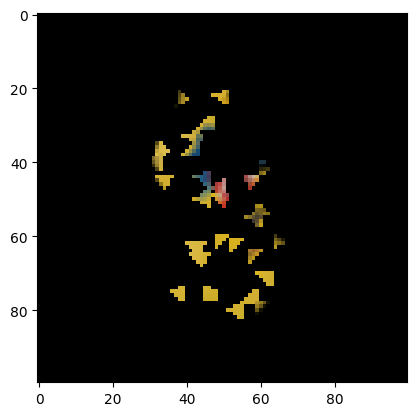

In [392]:
plt.imshow(im_mesh)

In [394]:
sub_i

Array([[1500, 1501, 1502],
       [1503, 1504, 1505],
       [1506, 1507, 1508],
       ...,
       [ 293, 1792, 1793],
       [ 296, 1795, 1796],
       [ 299, 1798, 1799]], dtype=int32)

In [396]:
len(sub_i)

400

In [ ]:
sub_i[:,:,]